# HSCT survival: clustering

## Notebook set-up

In [16]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier

import configuration as config

pd.set_option('display.max_rows', 500)

# Input files

# Dataset definition file
datasets_definitions_file=f'{config.DATA_PATH}/processed/02.1-dataset_definitions.pkl'

# Feature type definitions file
feature_types_dict_file=f'{config.DATA_PATH}/processed/01.1-feature_type_dict.pkl'

# Output files

# EFS+/- split regression results
efs_split_regression_results_file=f'{config.DATA_PATH}/results/02.2-efs_split_regression_results.pkl'

# Testing of different encoding strategies datasets for clustering
datasets_clustering_results_file=f'{config.DATA_PATH}/results/02.2-datasets_clustering_results.pkl'

# Testing regression on predicted EFS clusters
clustered_regression_results_file=f'{config.DATA_PATH}/results/02.2-clustered_regression_results.pkl'

randomsearch_depth=4
test_split_regression=False
test_data_tree_clustering=False
clustered_regression_test=True
train_nn=False

## 1. Load metadata

In [2]:
# Load dataset definitions
with open(datasets_definitions_file, 'rb') as input_file:
    datasets=pickle.load(input_file)

print('Datasets:\n')
for description, filepath in datasets.items():
    print(f' {description}')

# Load feature definitions
with open(feature_types_dict_file, 'rb') as input_file:
    feature_types=pickle.load(input_file)

print('\nFeature types:\n')
for feature_type, features in feature_types.items():
    print(f' {feature_type}: {features}\n')

Datasets:

 Nominal one-hot/ordinal encoded, NANs encoded
 Nominal one-hot/ordinal encoded, NANs imputed
 All ordinal encoded, NAN encoded
 All ordinal encoded, NAN imputed
 Binary target encoded
 Continuous target encoded

Feature types:

 Interval: ['donor_age', 'age_at_hct']

 Ordinal: ['hla_match_c_high', 'hla_high_res_8', 'hla_low_res_6', 'hla_high_res_6', 'hla_high_res_10', 'hla_match_dqb1_high', 'hla_nmdp_6', 'hla_match_c_low', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'year_hct', 'hla_match_a_high', 'hla_match_b_low', 'hla_match_a_low', 'hla_match_b_high', 'comorbidity_score', 'karnofsky_score', 'hla_low_res_8', 'hla_match_drb1_high', 'hla_low_res_10', 'dri_score', 'cyto_score', 'cmv_status', 'cyto_score_detail']

 Nominal: ['psych_disturb', 'diabetes', 'tbi_status', 'arrhythmia', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'tce_imm_match', 'rituximab', 'prod_type', 'conditioning_intensity', 'ethnicity', 'obesity', 'mrd_hct', 'in_vivo_tcd', 't

## 2. Does knowing the EFS label give better regression results?

### 2.1. Dataset preparation

In [3]:
if test_split_regression == True:
    
    efs_test_datasets={}

    # Pick and load the 'best' data
    data_df=pd.read_parquet(datasets['All ordinal encoded, NAN imputed'])

    # Take log of efs time
    data_df['efs_time']=np.log(data_df['efs_time'])

    # Split the data by EFS label
    efs_zero_df=data_df[data_df['efs'] == 0].copy()
    efs_one_df=data_df[data_df['efs'] == 1].copy()

    # Drop race group and collect
    combined_df=data_df.drop('race_group', axis=1, inplace=False).copy()
    efs_zero_df.drop('race_group', axis=1, inplace=True)
    efs_one_df.drop('race_group', axis=1, inplace=True)

    efs_test_datasets={
        'Combined': combined_df,
        'EFS 0': efs_zero_df,
        'EFS 1': efs_one_df
    }

### 2.2. Cross-validation with test datasets

In [4]:
if test_split_regression == True:
    
    cross_val_results={
        'Dataset':[],
        'Mean RMSE': [],
        'Standard deviation RMSE': []
    }

    # Define cross-validation strategy
    cv=ShuffleSplit(n_splits=10, test_size=0.3, random_state=315)

    # Loop on the datasets
    for dataset, dataset_df in efs_test_datasets.items():

        # Make features and labels
        labels_df=dataset_df[['efs', 'efs_time']].copy()
        features_df=dataset_df.drop(['efs', 'efs_time'], axis=1, inplace=False)

        scores=cross_val_score(
            GradientBoostingRegressor(random_state=315),
            features_df,
            labels_df['efs_time'],
            cv=cv,
            scoring='neg_root_mean_squared_error'
        )

        scores_mean=np.array(abs(scores)).mean()
        scores_std=np.array(abs(scores)).std()
        cross_val_results['Dataset'].append(dataset)
        cross_val_results['Mean RMSE'].append(scores_mean)
        cross_val_results['Standard deviation RMSE'].append(scores_std)

    cross_val_results_df=pd.DataFrame.from_dict(cross_val_results)
    efs_split_regression_results={'Cross-validation scores': cross_val_results_df}

else:

    # Load last result
    with open(efs_split_regression_results_file, 'rb') as input_file:
        efs_split_regression_results=pickle.load(input_file)

    cross_val_results_df=efs_split_regression_results['Cross-validation scores']

cross_val_results_df.head(len(cross_val_results_df))

,Dataset,Mean RMSE,Standard deviation RMSE
0,Combined,0.967509,0.004883
1,EFS 0,0.294643,0.003206
2,EFS 1,0.358651,0.003459


### 2.3. Hyperparameter tuning on test datasets

In [5]:
if test_split_regression == True:
    
    predictions={}
    labels={}
    best_parameters={}
    models={}

    # Define the cross-validation strategy
    cross_validation=ShuffleSplit(n_splits=10, test_size=0.3, random_state=315)

    # Loop on the datasets
    for dataset, dataset_df in efs_test_datasets.items():

        # Train test split
        training_df, testing_df=train_test_split(dataset_df, test_size=0.3, random_state=315)

        # Remove the labels
        training_labels_df=training_df[['efs', 'efs_time']].copy()
        training_features_df=training_df.drop(['efs', 'efs_time'], axis=1)
        testing_labels_df=testing_df[['efs', 'efs_time']].copy()
        testing_features_df=testing_df.drop(['efs', 'efs_time'], axis=1)

        # Instantiate the model
        tree_model=GradientBoostingRegressor(random_state=315)

        # Define the hyperparameter search space
        distributions={
            'learning_rate': stats.uniform(loc=0.0001, scale=0.0999),
            'n_estimators': list(range(10, 500)),
            'max_depth': list(range(5, 50)),
            'min_samples_split': list(range(2, 10)),
            'min_samples_leaf': list(range(1, 10)),
            'subsample': stats.uniform(loc=0.5, scale=0.4)
        }

        # Set-up the search
        search=RandomizedSearchCV(
            tree_model,
            distributions,
            scoring='neg_root_mean_squared_error',
            n_jobs=-1,
            cv=cross_validation,
            n_iter=randomsearch_depth,
            random_state=315,
            return_train_score=True
        )

        search_results=search.fit(training_features_df, training_labels_df['efs_time'])
        best_parameters[dataset]=search_results.best_params_

        # Train classifier with best hyperparameters on complete training set
        tree_model=GradientBoostingRegressor(**search_results.best_params_, random_state=315)
        result=tree_model.fit(training_features_df, training_labels_df['efs_time'])
        models[dataset]=tree_model

        # Make testing predictions
        testing_predictions=tree_model.predict(testing_features_df)
        predictions[dataset]=testing_predictions
        labels[dataset]=testing_labels_df['efs_time']

    efs_split_regression_results['Testing predictions']=predictions
    efs_split_regression_results['Testing labels']=labels
    efs_split_regression_results['Best parameters']=best_parameters
    efs_split_regression_results['Tuned models']=models

    with open(efs_split_regression_results_file, 'wb') as output_file:
        pickle.dump(efs_split_regression_results, output_file)

else:
    predictions=efs_split_regression_results['Testing predictions']
    labels=efs_split_regression_results['Testing labels']
    best_parameters=efs_split_regression_results['Best parameters']
    models=efs_split_regression_results['Tuned models']


### 2.4. Results

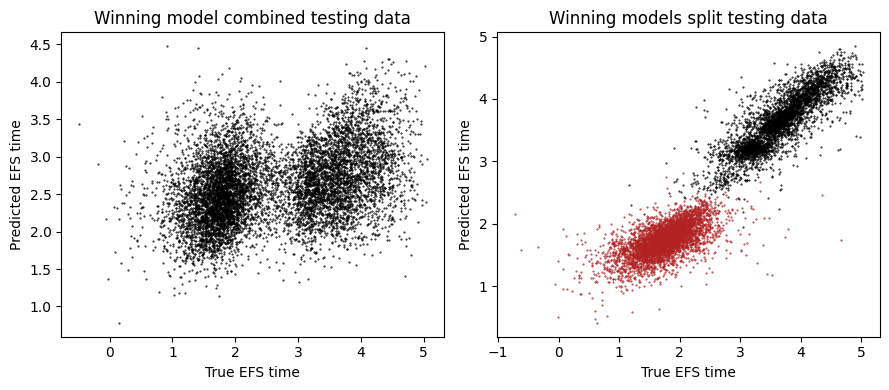

In [6]:
fig, axs=plt.subplots(1,2, figsize=(9,4))
axs=axs.flatten()

axs[0].set_title(f'Winning model combined testing data')
axs[0].scatter(labels['Combined'], predictions['Combined'], color='black', s=0.2)
axs[0].set_xlabel('True EFS time')
axs[0].set_ylabel('Predicted EFS time')

axs[1].set_title(f'Winning models split testing data')
axs[1].scatter(labels['EFS 0'], predictions['EFS 0'], s=0.2, color='black')
axs[1].scatter(labels['EFS 1'], predictions['EFS 1'], s=0.2, color='firebrick')
axs[1].set_xlabel('True EFS time')
axs[1].set_ylabel('Predicted EFS time')

fig.tight_layout()
fig.show()

## 3. Clustering

### 3.1. Gradient boosting

#### 3.1.1. Dataset evaluation

In [7]:
if test_data_tree_clustering == True:

    predictions={}
    labels={}
    best_parameters={}
    models={}

    # Define cross-validation strategy
    cross_validation=ShuffleSplit(n_splits=10, test_size=0.3, random_state=315)

    # Loop on the datasets
    for dataset, data_file in datasets.items():

        # Load the data
        data_df=pd.read_parquet(data_file)

        # Take log of efs time
        data_df['efs_time']=np.log(data_df['efs_time'])

        # Preserve unencoded race group
        race_group=data_df['race_group']
        data_df.drop('race_group', axis=1, inplace=True)

        # Train test split
        training_df, testing_df=train_test_split(data_df, test_size=0.3, random_state=315)

        # Remove the labels
        training_labels_df=training_df[['efs', 'efs_time']].copy()
        training_features_df=training_df.drop(['efs', 'efs_time'], axis=1)
        testing_labels_df=testing_df[['efs', 'efs_time']].copy()
        testing_features_df=testing_df.drop(['efs', 'efs_time'], axis=1)

        # Instantiate the model
        tree_model=GradientBoostingClassifier(random_state=315)

        # Define the hyperparameter search space
        distributions={
            'learning_rate': stats.uniform(loc=0.0001, scale=0.0999),
            'n_estimators': list(range(10, 500)),
            'max_depth': list(range(5, 50)),
            'min_samples_split': list(range(2, 10)),
            'min_samples_leaf': list(range(1, 10)),
            'subsample': stats.uniform(loc=0.5, scale=0.4)
        }

        # Set-up the search
        search=RandomizedSearchCV(
            tree_model,
            distributions,
            scoring='neg_root_mean_squared_error',
            n_jobs=-1,
            cv=cross_validation,
            n_iter=randomsearch_depth,
            random_state=315,
            return_train_score=True
        )

        search_results=search.fit(training_features_df, training_labels_df['efs'])
        best_parameters[dataset]=search_results.best_params_

        # Train classifier with best hyperparameters on complete training set
        tree_model=GradientBoostingClassifier(**search_results.best_params_, random_state=315)
        result=tree_model.fit(training_features_df, training_labels_df['efs'])
        models[dataset]=tree_model

        # Make testing predictions
        testing_predictions=tree_model.predict(testing_features_df)
        predictions[dataset]=testing_predictions
        labels[dataset]=testing_labels_df['efs']

    datasets_clustering_results={'Testing predictions': predictions}
    datasets_clustering_results['Testing labels']=labels
    datasets_clustering_results['Best parameters']=best_parameters
    datasets_clustering_results['Tuned models']=models

    with open(datasets_clustering_results_file, 'wb') as output_file:
        pickle.dump(datasets_clustering_results, output_file)

else:

    # Load last result
    with open(datasets_clustering_results_file, 'rb') as input_file:
        datasets_clustering_results=pickle.load(input_file)

    predictions=datasets_clustering_results['Testing predictions']
    labels=datasets_clustering_results['Testing labels']
    best_parameters=datasets_clustering_results['Best parameters']
    models=datasets_clustering_results['Tuned models']

#### 3.1.2. Clustering results

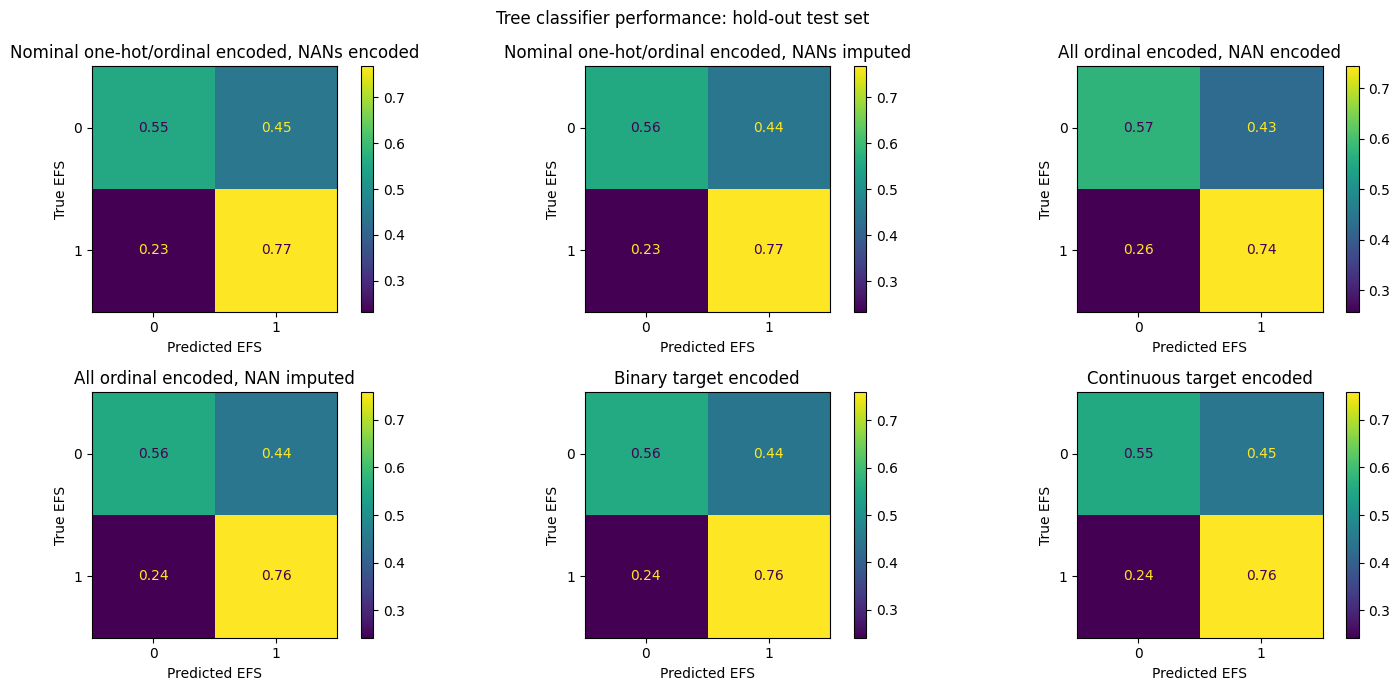

In [8]:
fig, axs=plt.subplots(2,3, figsize=(15,7))
axs=axs.flatten()

fig.suptitle('Tree classifier performance: hold-out test set')

for i, dataset in enumerate(predictions.keys()):

    # Plot the confusion matrix
    cm=confusion_matrix(labels[dataset], predictions[dataset], normalize='true')
    cm_disp=ConfusionMatrixDisplay(confusion_matrix=cm)
    _=cm_disp.plot(ax=axs[i])

    axs[i].set_title(dataset)
    axs[i].set_xlabel('Predicted EFS')
    axs[i].set_ylabel('True EFS')

fig.tight_layout()
fig.show()

#### 3.1.3. Regression on clusters

In [18]:
if clustered_regression_test == True:

    # Pick the 'best' model and dataset
    winner='All ordinal encoded, NAN imputed'
    data_df_file=datasets[winner]
    model=models[winner]

    # Load the data
    data_df=pd.read_parquet(data_df_file)

    # Drop race group
    data_df.drop('race_group', axis=1, inplace=True)

    # Take log of efs time
    data_df['efs_time']=np.log(data_df['efs_time'])

    # Label dataset with EFS predictions
    data_df['predicted_efs']=model.predict(data_df.drop(['efs', 'efs_time'], axis=1))

    # Split the data by predicted EFS label
    efs_zero_df=data_df[data_df['predicted_efs'] == 0].copy()
    efs_one_df=data_df[data_df['predicted_efs'] == 1].copy()

    regression_test_datasets={
        'Combined': data_df,
        'Predicted EFS 0': efs_zero_df,
        'Predicted EFS 1': efs_one_df
    }

In [20]:
if clustered_regression_test == True:
    
    cross_val_results={
        'Dataset':[],
        'Mean RMSE': [],
        'Standard deviation RMSE': []
    }

    # Define cross-validation strategy
    cv=ShuffleSplit(n_splits=10, test_size=0.3, random_state=315)

    # Loop on the datasets
    for dataset, dataset_df in regression_test_datasets.items():

        # Make features and labels
        labels_df=dataset_df[['efs', 'efs_time']].copy()
        features_df=dataset_df.drop(['efs', 'efs_time'], axis=1, inplace=False)

        scores=cross_val_score(
            GradientBoostingRegressor(random_state=315),
            features_df,
            labels_df['efs_time'],
            cv=cv,
            scoring='neg_root_mean_squared_error'
        )

        scores_mean=np.array(abs(scores)).mean()
        scores_std=np.array(abs(scores)).std()
        cross_val_results['Dataset'].append(dataset)
        cross_val_results['Mean RMSE'].append(scores_mean)
        cross_val_results['Standard deviation RMSE'].append(scores_std)

    cross_val_results_df=pd.DataFrame.from_dict(cross_val_results)
    clustered_regression_results={'Cross-validation scores': cross_val_results_df}

else:

    # Load last result
    with open(clustered_regression_results_file, 'rb') as input_file:
        clustered_regression_results=pickle.load(input_file)

    cross_val_results_df=clustered_regression_results['Cross-validation scores']

cross_val_results_df.head(len(cross_val_results_df))

,Dataset,Mean RMSE,Standard deviation RMSE
0,Combined,0.736302,0.150386
1,Predicted EFS 0,0.633486,0.011716
2,Predicted EFS 1,0.714929,0.009558


In [21]:
if clustered_regression_test == True:
    
    predictions={}
    labels={}
    best_parameters={}
    models={}

    # Define the cross-validation strategy
    cross_validation=ShuffleSplit(n_splits=10, test_size=0.3, random_state=315)

    # Loop on the datasets
    for dataset, dataset_df in regression_test_datasets.items():

        # Train test split
        training_df, testing_df=train_test_split(dataset_df, test_size=0.3, random_state=315)

        # Remove the labels
        training_labels_df=training_df[['efs', 'efs_time']].copy()
        training_features_df=training_df.drop(['efs', 'efs_time'], axis=1)
        testing_labels_df=testing_df[['efs', 'efs_time']].copy()
        testing_features_df=testing_df.drop(['efs', 'efs_time'], axis=1)

        # Instantiate the model
        tree_model=GradientBoostingRegressor(random_state=315)

        # Define the hyperparameter search space
        distributions={
            'learning_rate': stats.uniform(loc=0.0001, scale=0.0999),
            'n_estimators': list(range(10, 500)),
            'max_depth': list(range(5, 50)),
            'min_samples_split': list(range(2, 10)),
            'min_samples_leaf': list(range(1, 10)),
            'subsample': stats.uniform(loc=0.5, scale=0.4)
        }

        # Set-up the search
        search=RandomizedSearchCV(
            tree_model,
            distributions,
            scoring='neg_root_mean_squared_error',
            n_jobs=-1,
            cv=cross_validation,
            n_iter=randomsearch_depth,
            random_state=315,
            return_train_score=True
        )

        search_results=search.fit(training_features_df, training_labels_df['efs_time'])
        best_parameters[dataset]=search_results.best_params_

        # Train classifier with best hyperparameters on complete training set
        tree_model=GradientBoostingRegressor(**search_results.best_params_, random_state=315)
        result=tree_model.fit(training_features_df, training_labels_df['efs_time'])
        models[dataset]=tree_model

        # Make testing predictions
        testing_predictions=tree_model.predict(testing_features_df)
        predictions[dataset]=testing_predictions
        labels[dataset]=testing_labels_df['efs_time']

    clustered_regression_results['Testing predictions']=predictions
    clustered_regression_results['Testing labels']=labels
    clustered_regression_results['Best parameters']=best_parameters
    clustered_regression_results['Tuned models']=models

    with open(clustered_regression_results_file, 'wb') as output_file:
        pickle.dump(clustered_regression_results, output_file)

else:
    predictions=clustered_regression_results['Testing predictions']
    labels=clustered_regression_results['Testing labels']
    best_parameters=clustered_regression_results['Best parameters']
    models=clustered_regression_results['Tuned models']


#### 3.1.4. Regression results

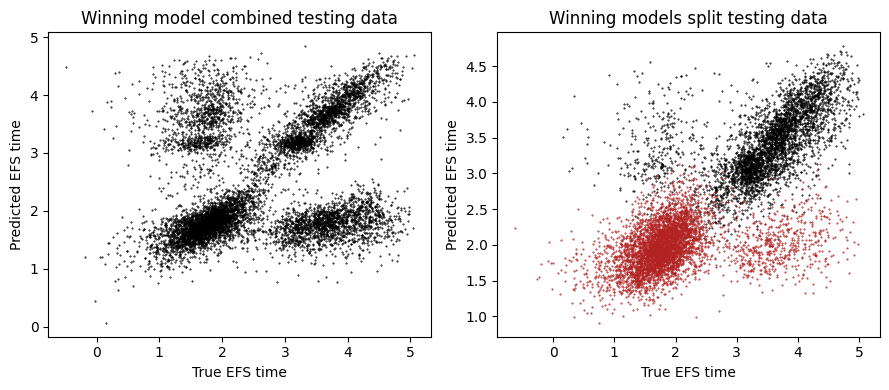

In [24]:
fig, axs=plt.subplots(1,2, figsize=(9,4))
axs=axs.flatten()

axs[0].set_title(f'Winning model combined testing data')
axs[0].scatter(labels['Combined'], predictions['Combined'], color='black', s=0.2)
axs[0].set_xlabel('True EFS time')
axs[0].set_ylabel('Predicted EFS time')

axs[1].set_title(f'Winning models split testing data')
axs[1].scatter(labels['Predicted EFS 0'], predictions['Predicted EFS 0'], s=0.2, color='black')
axs[1].scatter(labels['Predicted EFS 1'], predictions['Predicted EFS 1'], s=0.2, color='firebrick')
axs[1].set_xlabel('True EFS time')
axs[1].set_ylabel('Predicted EFS time')

fig.tight_layout()
fig.show()

### 3.2. Neural network

In [11]:
l1=0.002
l2=0.0002
learning_rate=0.00001

In [12]:
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

if train_nn == True:

    # Set the weight initializer function
    initializer=GlorotUniform(seed=315)

    # Set-up the L1L2 for the dense layers
    regularizer=L1L2(l1=l1, l2=l2)

    # Define the model layers in order
    nn_model=Sequential([
        Dense(128, kernel_regularizer=regularizer, activation='relu', kernel_initializer=initializer),
        Dense(256, kernel_regularizer=regularizer, activation='relu', kernel_initializer=initializer),
        Dense(256, kernel_regularizer=regularizer, activation='relu', kernel_initializer=initializer),
        Dense(256, kernel_regularizer=regularizer, activation='relu', kernel_initializer=initializer),
        Dense(128, kernel_regularizer=regularizer, activation='relu', kernel_initializer=initializer),
        Dense(64, kernel_regularizer=regularizer, activation='relu', kernel_initializer=initializer),
        Dense(32, kernel_regularizer=regularizer, activation='relu', kernel_initializer=initializer),
        Dense(16, kernel_regularizer=regularizer, activation='relu', kernel_initializer=initializer),
        Dense(1, activation='sigmoid', kernel_initializer=initializer)
    ])

    nn_model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=learning_rate),
        metrics=[Precision(name='precision'), Recall(name='recall')]
    )

    # Calculate class weighting
    pos_examples=sum(training_labels_df['efs'])
    neg_examples=len(training_labels_df['efs']) - pos_examples
    neg_class_weight=(1 / neg_examples) * (len(training_labels_df['efs']) / 2.0)
    pos_class_weight=(1 / pos_examples) * (len(training_labels_df['efs']) / 2.0)

    # Do the training run
    training_results=nn_model.fit(
        training_features_df,
        training_labels_df['efs'],
        batch_size=256,
        validation_split=0.25,
        epochs=5000,
        verbose=False,
        class_weight={0: neg_class_weight, 1: pos_class_weight}
    )

2025-02-22 12:48:23.952718: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2025-02-22 12:48:23.952873: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2025-02-22 12:48:23.952891: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [13]:
if train_nn == True:
    
    # Set-up a 1x2 figure for binary cross-entropy, precision & recall
    fig, axs=plt.subplots(1,3, figsize=(12,3))

    # Add the main title
    fig.suptitle('Classifier training curves', size='large')

    axs[0].set_title('Binary cross-entropy')
    axs[0].plot(training_results.history['loss'], label='Training')
    axs[0].plot(training_results.history['val_loss'], label='Validation')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Binary cross-entropy')
    axs[0].legend(loc='upper left')

    axs[1].set_title('Precision')
    axs[1].plot(training_results.history['precision'])
    axs[1].plot(training_results.history['val_precision'])
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Precision')

    axs[2].set_title('Recall')
    axs[2].plot(training_results.history['recall'])
    axs[2].plot(training_results.history['val_recall'])
    axs[2].set_xlabel('Epoch')
    axs[2].set_ylabel('Recall')

    # Show the plot
    plt.tight_layout()

In [14]:
if train_nn == True:
    
    predictions=nn_model.predict(testing_features_df)
    calls=list(np.where(np.array(predictions) > 0.5, 1, 0))

    # Calculate precision and recall
    precision=precision_score(testing_labels_df['efs'], calls)
    recall=recall_score(testing_labels_df['efs'], calls)

    # Plot the confusion matrix
    cm=confusion_matrix(testing_labels_df['efs'], calls, normalize='true')
    cm_disp=ConfusionMatrixDisplay(confusion_matrix=cm)#, display_labels=['0', 'EFS 1'])
    _=cm_disp.plot()

    plt.title('Test set gradient boosting classifier performance')
    plt.xlabel('Predicted EFS')
    plt.ylabel('True EFS')
    plt.tight_layout()
    plt.show()

    print(f'Precision: {precision:.3f}')
    print(f'Recall: {recall:.3f}\n')